---


<p align="center">
   <!---<img src="https://www.estudiaradistancia.com.ar/logos/original/logo-universidad-de-buenos-aires.webp" height=80 />--->
   <img src="https://confedi.org.ar/wp-content/uploads/2020/09/fiuba_logo.jpg" height="180"/>
</p>

---

<center><font size="+2">
  <h1> 75.26 / 95.19 Simulación </h1>

  <h2> Trabajo Práctico II </h2>

  <h3> Segundo Cuatrimestre - 2022 </h3>

</font></center>

---

<center><font size="+1">

  <h2>GRUPO 4</h2>

  <h2>INTEGRANTES</h2>

  <h4>Gestoso, Ramiro</h4>
  <h4>Brizuela Lopez, Mariano</h4>
  <h4>Markarian, Darío Hernan</h4>
  <h4>Ripetour, Diego</h4>

</font></center>


---

### Importamos librerias necesarias

In [1]:
import random
import urllib.request
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
from bs4 import BeautifulSoup

np.random.seed(31)

# Ejercicio 1

## Algoritmo de simulación de cadena de Markov

Dada matriz cuadrada que contenga en la posición i,j la probabilidad de cambiar de estado i a j y una cantidad n, se simula el cambio de estado de esta cadena n veces.

Se puede indicar un estado inicial (debe estar incluido en la matriz). Si no se lo indica, se toma uno al azar.

In [2]:
def simular_markov(matriz_estados, cantidad_simulaciones, estado_inicial=None):
    if estado_inicial == None:
        # Elijimos uno random de los n para iniciar
        v = random.randint(0, len(matriz_estados)-1)
    
    estados_recorridos = []
    
    # Obtenemos el array de probabilidades del nodo v
    prob_estados = matriz_estados[v]
    
    for i in range(cantidad_simulaciones):
        estados_recorridos.append(v)
        # Simulamos una probabilidad que nos ayudará a elegir el próximo estado
        u = random.random()
        
        prob_acum = 0
        for j in range(len(matriz_estados)):
            prob_acum += prob_estados[j]
            if u <= prob_acum:
                # Actualizamos el nodo y el array de probabilidades
                v = j
                prob_estados = matriz_estados[v]
                break
    return estados_recorridos

## Algoritmo para simular búsquedas con los resultados de Pagerank

## Algoritmo de Pagerank 

Es un algoritmo simple en el cual se crea la matriz de probabilidades según la cantidad de apariciones de una pagina en otra.
Si una pagina no contiene ninguna referencia, se toma la hipótesis de que el usuario elige una página al azar, todas con misma probabilidad, pero no vuelve a elegir la misma en la que estaba.

Una vez obtenida la matriz, se estima n tendiendo a infinito (ahora se usa un numero mucho menor) para calcular la cantidad de tiempo que un usuario está en cada página.

In [3]:
def matriz_probabilidades(paginas):
    # Matriz donde almacenamos la referencia de la pagina en la pos i
    referencias = [[] for i in paginas]
    
    cant_paginas = len(paginas)
    
    # Recorremos las paginas y obtenemos las referencias a otras paginas
    for i in range(len(paginas)):
        html_page = urllib.request.urlopen("file:paginas/" + paginas[i])
        soup = BeautifulSoup(html_page, "html.parser")
        for link in soup.findAll('a'):
            referencias[i].append(link.get('href').lstrip('http://'))
    
    matriz = [ [] for i in range(len(paginas)) ]

    for i in range(len(referencias)):

        referidas = referencias[i]
        cantidad_referidas = len(referidas)

        if cantidad_referidas == 0:
            # Se le aplica la misma probabilidad a cada pagina (menos a ella misma)
            matriz[i] = [1/(cant_paginas-1) if j!=i else 0 for j in range(cant_paginas)]
        else:
            # Se le aplica la frecuencia relativa de todas las paginas que aparecen
            matriz[i] = [ referidas.count(pagina)/cantidad_referidas for pagina in paginas ]
            
    return matriz

def pagerank(paginas, power=100):
    '''
    Se puede elegir un numero arbitario para elevar la matriz con el parametro power.
    Cuanto mas alto, mas precision. Para nuestro ejemplo con 100 alcanza y sobra.
    '''
    matriz_paginas = np.array(matriz_probabilidades(paginas))
    return np.linalg.matrix_power(matriz_paginas, power)[0]


## Simulaciones y resultados

#### Generamos la matriz que representa la probabilidad de navegar por cada pagina a partir de la anterior (Cadena de Markov)

In [4]:
pags = [
    'angelinajolie.html',
    'bradpitt.html',
    'jenniferaniston.html',
    'jonvoight.html',
    'martinscorcese.html',
    'robertdeniro.html'
]
matriz = matriz_probabilidades(pags)

#### Visualizamos la matriz de probabilidades

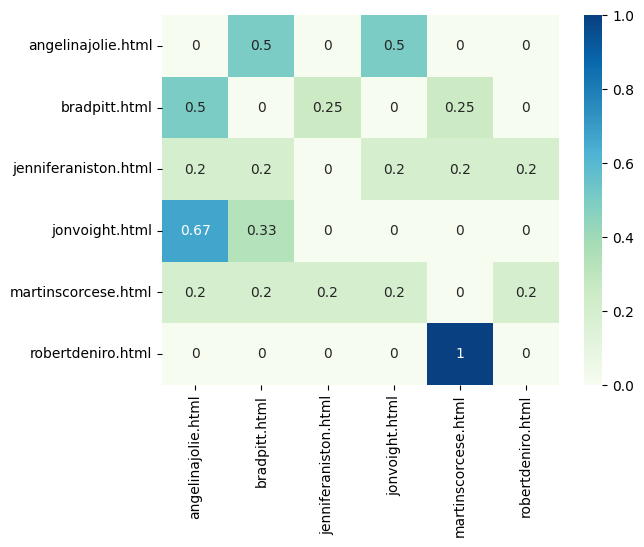

In [5]:
sns.heatmap(matriz, annot=True, cmap='GnBu', xticklabels=pags, yticklabels=pags)
plt.show()

#### Realizamos una simulación de un usuario navegando por las paginas y graficamos la probabilidad de visitas de cada una

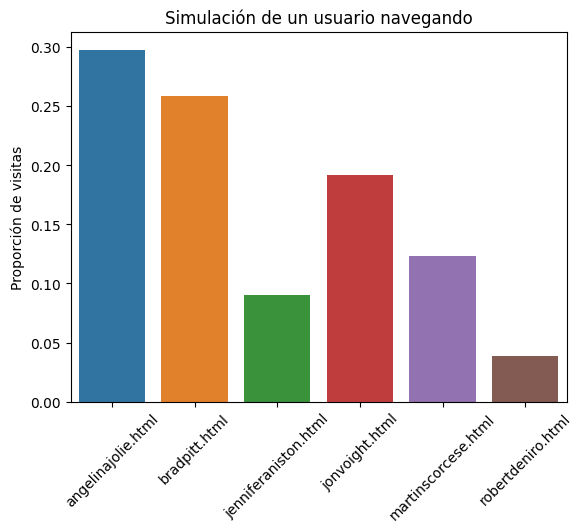

In [6]:
n = 10_000
estados = simular_markov(matriz, n)
unique, counts = np.unique(estados, return_counts=True)
sns.barplot(x=pags, y=(counts/n))
plt.title('Simulación de un usuario navegando')
plt.xticks(rotation = 45)
plt.ylabel('Proporción de visitas')
plt.show()

#### Ahora calculamos y graficamos el Pagerank de cada página

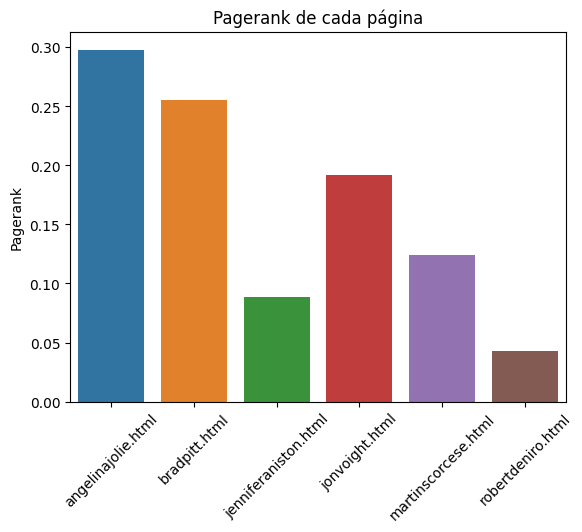

In [7]:
pageranks = pagerank(pags)
sns.barplot(x=pags, y=pageranks)
plt.title('Pagerank de cada página')
plt.xticks(rotation = 45)
plt.ylabel('Pagerank')
plt.show()

Podemos observar que ambos graficos coinciden. Si bien representan lo mismo, los resultados se obtuvieron por caminos diferentes.

En el primer caso, se realizó una simulación de un usuario navegando por las páginas a través de los links referidos y se obtuvo la proporción de veces que el usuario visitó cada página.

En el segundo caso, se obtuvo un resultado más teórico (si bien no se calculó el comportamiento asintótico, se aproximó) que representa la probabilidad de terminar en una página. Esta probabilidad representará el Pagerank de la pagina y representará la importancia de la misma

### Simulación de busquedas

Algoritmo para obtener palabras al azar contenidas en un conjunto de paginas.

In [7]:
def obtenerPalabrasAlAzarDePaginas(paginas, n):
    palabras = set()
    for pag in paginas:
        html_page = urllib.request.urlopen("file:paginas/" + pag)
        soup = BeautifulSoup(html_page, "html.parser")
        for body in soup.findAll('body'):
            body = re.sub('[\[({<,.>})\]]', '', body.get_text())
            body.replace('/', ' ')
            for word in body.split():
                palabras.add(word)
    return random.sample(list(palabras), n)

Algoritmo que dado un conjunto de palabras y de paginas, busca cada palabra en las paginas.

Si la palabra está en la página, la muestra en el resultado de búsqueda. Las páginas son mostradas en el orden determinado por su pagerank.

In [5]:
def obtenerBodyDePaginas(paginas):
    bodies = {}
    for pag in paginas:
        html_page = urllib.request.urlopen("file:paginas/" + pag)
        soup = BeautifulSoup(html_page, "html.parser")
        for body in soup.findAll('body'):
            bodies[pag] = body.get_text()
    return bodies

def paginasPorPalabra(paginas, palabras):
    paginasPorPalabras = {}
    for palabra in palabras:
        paginasPorPalabras[palabra] = []
        
    pageranks = sorted(list(zip(paginas, pagerank(paginas))), key=lambda x: -x[1])
    bodies = obtenerBodyDePaginas(paginas)
    for palabra in palabras:
        for pagina,_ in pageranks:
            if palabra in bodies[pagina]:
                paginasPorPalabras[palabra].append(pagina)
    return paginasPorPalabras

Simulamos la búsqueda de palabras e imprimimos los resultados para cada una.

In [8]:
palabras = obtenerPalabrasAlAzarDePaginas(pags, 20)
pagsPorPlabra = paginasPorPalabra(pags, palabras)

print('Busqueda de palabras:')
for palabra, paginas in pagsPorPlabra.items():
    print('\n' + palabra)
    for pagina in paginas:
        print('\t- ' + pagina)

Busqueda de palabras:

Eleven
	- bradpitt.html

other
	- bradpitt.html
	- jonvoight.html
	- jenniferaniston.html

early
	- robertdeniro.html

Plan
	- bradpitt.html

Club
	- bradpitt.html

Actors
	- angelinajolie.html
	- jenniferaniston.html

international
	- bradpitt.html

from
	- angelinajolie.html
	- martinscorcese.html
	- jenniferaniston.html

Four
	- bradpitt.html

Award
	- angelinajolie.html
	- bradpitt.html
	- jonvoight.html
	- martinscorcese.html
	- jenniferaniston.html
	- robertdeniro.html

United
	- bradpitt.html

leading
	- angelinajolie.html
	- bradpitt.html
	- jonvoight.html

Voight
	- angelinajolie.html
	- jonvoight.html

Raider
	- angelinajolie.html

become
	- bradpitt.html

George
	- angelinajolie.html

Polly
	- jenniferaniston.html

at
	- angelinajolie.html
	- bradpitt.html
	- jonvoight.html
	- martinscorcese.html
	- robertdeniro.html

significant
	- martinscorcese.html

soap
	- bradpitt.html


# Ejercicio 2

Podemos obtener las probabilidades de estado estacionario del sistema para n solicitudes asi:

$ p_n=\frac{(\frac{\lambda}{\mu})^n \cdot e^-\frac{\lambda}{\mu}}{n!} $

Podemos obtener la longitud promedio de imagenes en cola esperando ser procesadas de la siguiente forma:

$ L=\sum n\cdot p_n=n \cdot z$

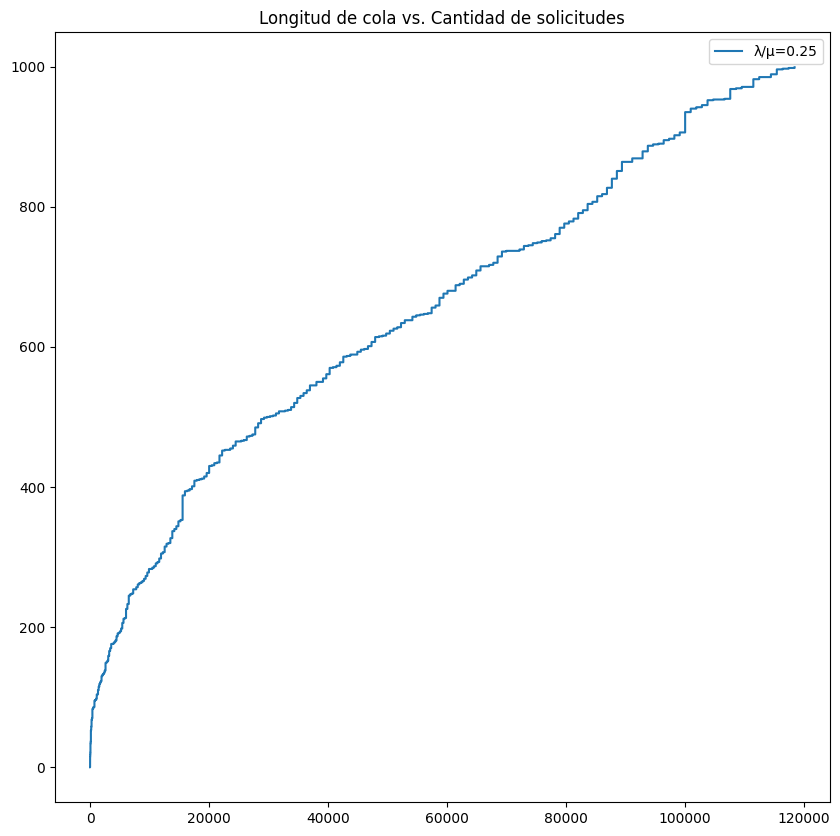

In [11]:
CANT_MAX_SOLICITUDES=1000
l=[]
arribo=0
lamb=0.25
mu=1
ro=lamb/mu

for n in range (CANT_MAX_SOLICITUDES):
    z= np.random.poisson(ro)
    arribo=arribo+n*z
    l.append(arribo)

plt.figure(figsize=(10,10))
plt.step(l,range(len(l)),where= 'post' ,label='λ/μ=0.25')
plt.legend()
plt.title("Longitud de cola vs. Cantidad de solicitudes")
plt.show()

# Ejercicio 3

## Creamos una clase que permita simular llamadas a un Web Service

In [12]:
class WebServiceSim:
    
    def simularDosDB(self, n, media_llamadas, media_demora_db1, media_demora_db2, p_db1):
        if p_db1 > 1:
            raise Exception('La probabilidad p debe ser menor o igual a 1')
            
        return self._simularLlamadas(n, media_llamadas, media_demora_db1, media_demora_db2, p_db1)
    
    def simularUnaDB(self, n, media_llamadas, media_demora_db):
        return self._simularLlamadas(n, media_llamadas, media_demora_db)
    
    def _simularLlamadas(self, n, media_llamadas, media_atencion_db1, media_atencion_db2 = None, p_db1 = 1):
        '''
        Simula llamadas a servidores que serán atendidas por una o dos bases de datos.
        Si no se indica el parametro "media_atencion_db2" se usa una sola base de datos.
        Si se indica el parametro, se puede indicar la probabilidad "p" que determina la 
            probabilidad de que una llamada sea atendida por la base de datos 1. Y "1-p"
            será la probabilidad de que sea atendida por la base de datos 2.
        '''
        t_actual = 0
        llamadas_sin_esperar = 0
        t_demora_solicitud = 0
        t_demoras_solicitudes = []

        llamadas = np.random.exponential(media_llamadas, n).cumsum()

        for t_llamada in llamadas:
            
            # Hay 2 bases de datos para elegir
            if p_db1 != 1:
                t_procesarLlamada = self._calcularProcesarConDosDB(media_atencion_db1, media_atencion_db2, p_db1)
            
            # Hay una sola base de datos
            else:
                t_procesarLlamada = np.random.exponential(media_atencion_db1)
            
            # Cuanto espera para hacer la llamada
            t_espera = t_actual - t_llamada
            
            # No espera para hacer la llamada
            if t_espera <= 0:
                t_demora_solicitud = t_procesarLlamada
                t_actual = t_llamada + t_procesarLlamada
                llamadas_sin_esperar += 1
            
            # Tiene espera para hacer la llamada
            else:
                t_demora_solicitud = t_espera + t_procesarLlamada
                t_actual = t_actual + t_procesarLlamada
            
            # Se cuenta la demora total de la solicitud
            t_demoras_solicitudes.append(t_demora_solicitud)
        
        
        t_demoras_solicitudes = np.array(t_demoras_solicitudes)
        
        ret = {
            'demora_total_promedio': t_demoras_solicitudes.mean(),
            'sin_esperar_probabilidad': llamadas_sin_esperar / n
        }

        return ret 
    
    def _calcularProcesarConDosDB(self, media_atencion_db1, media_atencion_db2, p_db1):
        u = np.random.random()
        if u < p_db1:
            return np.random.exponential(media_atencion_db1) 
        else:
            return np.random.exponential(media_atencion_db2) 

### Simulamos los dos casos propuestos por el ejercicio

In [13]:
sim = WebServiceSim()
simulacion_alternativa1 = sim.simularDosDB(100_000, 4, 0.7, 1, 0.7)
simulacion_alternativa2 = sim.simularUnaDB(100_000, 4, 0.8)

### Con los resultados graficamos y constrastamos las dos alternativas

Text(0, 0.5, 'Tiempo de demora promedio en segundos')

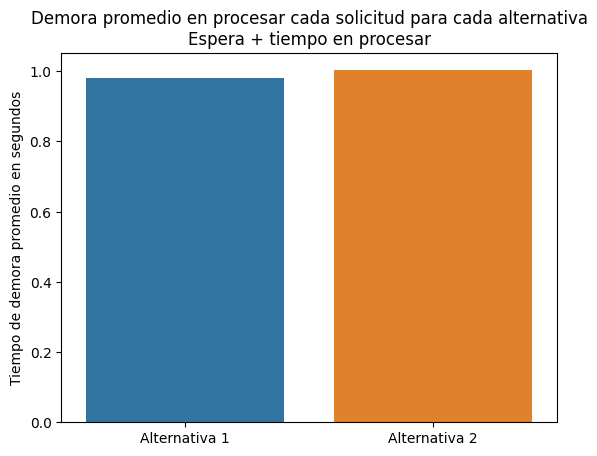

In [14]:
esperas = [
    simulacion_alternativa1['demora_total_promedio'],
    simulacion_alternativa2['demora_total_promedio']
]
grf = sns.barplot(x=['Alternativa 1','Alternativa 2'], y=esperas)
grf.set_title('Demora promedio en procesar cada solicitud para cada alternativa\nEspera + tiempo en procesar')
grf.set_ylabel('Tiempo de demora promedio en segundos')

Text(0, 0.5, 'Proporción de llamadas sobre el total')

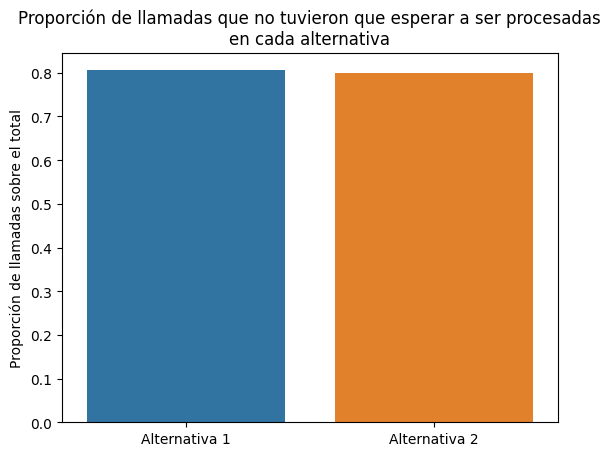

In [15]:
sin_espera = [
    simulacion_alternativa1['sin_esperar_probabilidad'],
    simulacion_alternativa2['sin_esperar_probabilidad']
]
grf = sns.barplot(x=['Alternativa 1','Alternativa 2'], y=sin_espera)
grf.set_title('Proporción de llamadas que no tuvieron que esperar a ser procesadas\nen cada alternativa')
grf.set_ylabel('Proporción de llamadas sobre el total')

Analizando los resultados podemos pensar que las alternativas tienen resultados similares, no notamos que en un caso una sea mucho mejor que otra.

## Realizamos otras simulaciones variando parámetros (uno a la vez)

Para cada variación, los mejores resultados serán aquellos que tengan el menor tiempo de espera promedio y la mayor proporción de llamadas que no esperaron en ser atendidas.

### Para la alternativa 1

#### Variamos p

In [16]:
sim = WebServiceSim()
valores_p = np.linspace(0.01, 0.99, 50)
demoras = []
sin_esperar = []
for p in valores_p:
    res = sim.simularDosDB(20_000, 4, 0.7, 1, p)
    demoras.append(res['demora_total_promedio'])
    sin_esperar.append(res['sin_esperar_probabilidad'])

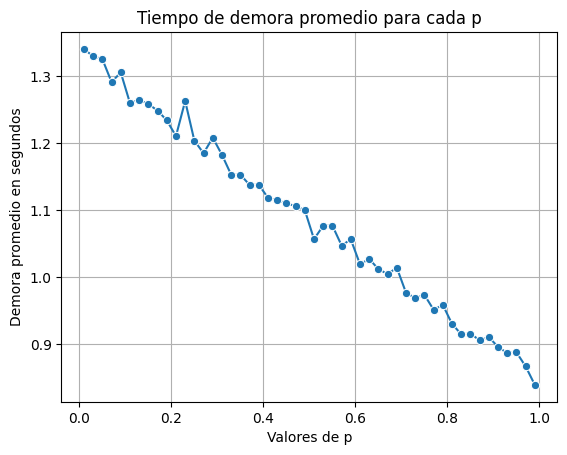

In [17]:
sns.lineplot(x=valores_p, y=demoras, marker='o')
plt.grid()
plt.title('Tiempo de demora promedio para cada p')
plt.ylabel('Demora promedio en segundos')
plt.xlabel('Valores de p')
plt.show()

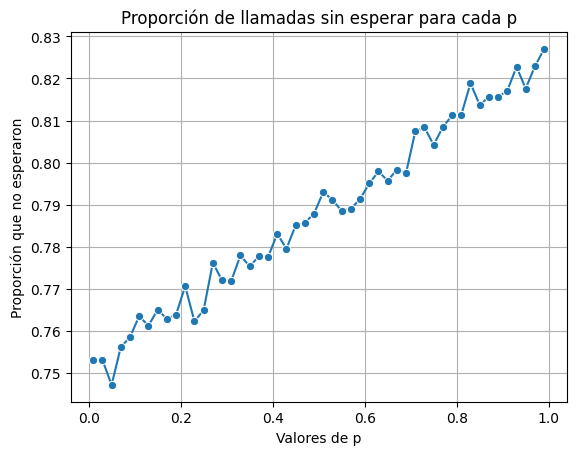

In [18]:
sns.lineplot(x=valores_p, y=sin_esperar, marker='o')
plt.grid()
plt.title('Proporción de llamadas sin esperar para cada p')
plt.ylabel('Proporción que no esperaron')
plt.xlabel('Valores de p')
plt.show()

#### Variamos la media de llamadas de la base de datos 2

In [19]:
medias_db2 = np.linspace(0.2, 1, 50)
demoras = []
sin_esperar = []
for mu in medias_db2:
    res = sim.simularDosDB(20_000, 4, 0.7, mu, 0.7)
    demoras.append(res['demora_total_promedio'])
    sin_esperar.append(res['sin_esperar_probabilidad'])

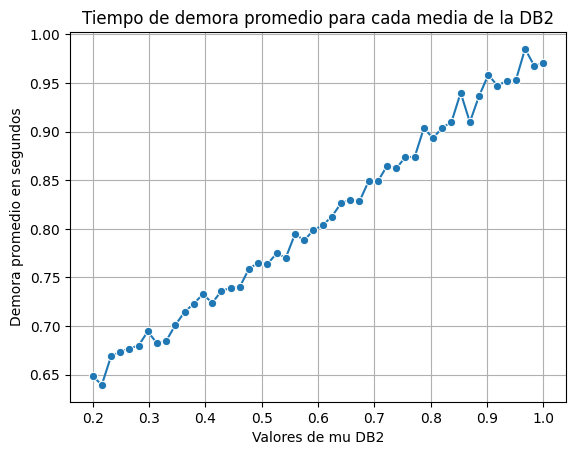

In [20]:
sns.lineplot(x=medias_db2, y=demoras, marker='o')
plt.grid()
plt.title('Tiempo de demora promedio para cada media de la DB2')
plt.ylabel('Demora promedio en segundos')
plt.xlabel('Valores de mu DB2')
plt.show()

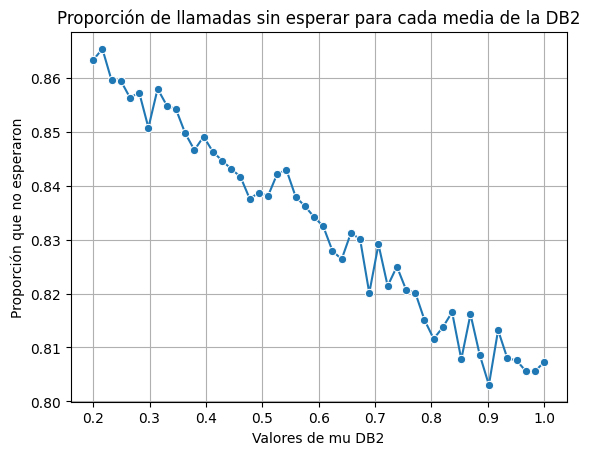

In [21]:
sns.lineplot(x=medias_db2, y=sin_esperar, marker='o')
plt.grid()
plt.title('Proporción de llamadas sin esperar para cada media de la DB2')
plt.ylabel('Proporción que no esperaron')
plt.xlabel('Valores de mu DB2')
plt.show()

### Para la alternativa 1

#### Variamos la media de llamadas

In [22]:
medias_llamadas = np.linspace(1, 7, 50)
demoras = []
sin_esperar = []
for mu in medias_llamadas:
    res = sim.simularUnaDB(20_000, mu, 0.8)
    demoras.append(res['demora_total_promedio'])
    sin_esperar.append(res['sin_esperar_probabilidad'])

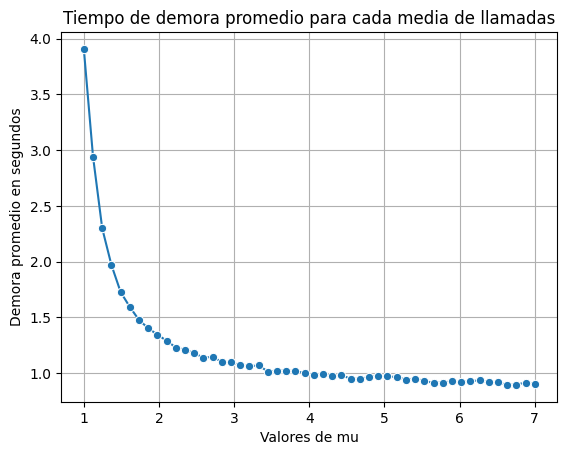

In [23]:
sns.lineplot(x=medias_llamadas, y=demoras, marker='o')
plt.grid()
plt.title('Tiempo de demora promedio para cada media de llamadas')
plt.ylabel('Demora promedio en segundos')
plt.xlabel('Valores de mu')
plt.show()

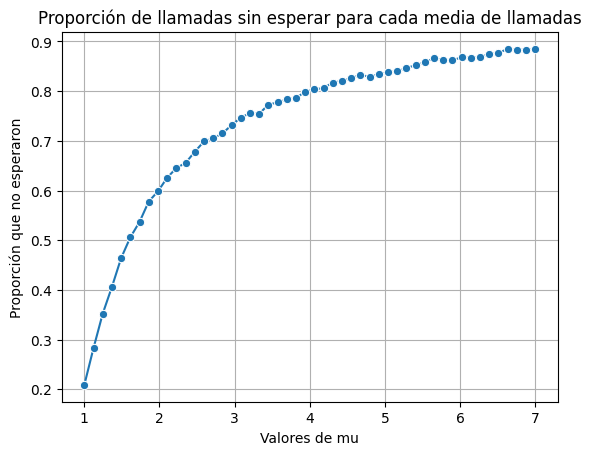

In [24]:
sns.lineplot(x=medias_llamadas, y=sin_esperar, marker='o')
plt.grid()
plt.title('Proporción de llamadas sin esperar para cada media de llamadas')
plt.ylabel('Proporción que no esperaron')
plt.xlabel('Valores de mu')
plt.show()

#### Variamos la media de atencion de la DB

In [25]:
medias_db = np.linspace(0.5, 4, 50)
demoras = []
sin_esperar = []
for mu in medias_db:
    res = sim.simularUnaDB(20_000, 4, mu)
    demoras.append(res['demora_total_promedio'])
    sin_esperar.append(res['sin_esperar_probabilidad'])

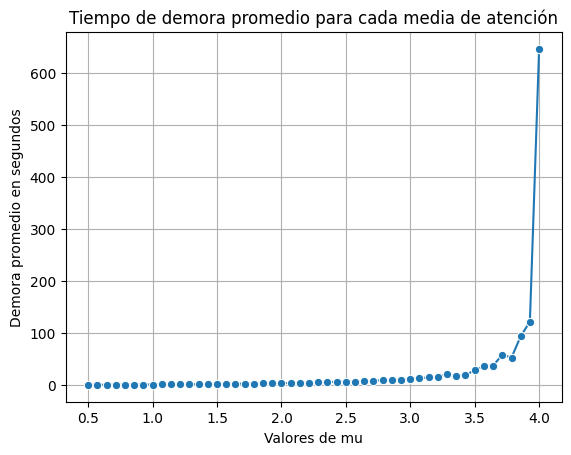

In [26]:
sns.lineplot(x=medias_db, y=demoras, marker='o')
plt.grid()
plt.title('Tiempo de demora promedio para cada media de atención')
plt.ylabel('Demora promedio en segundos')
plt.xlabel('Valores de mu')
plt.show()

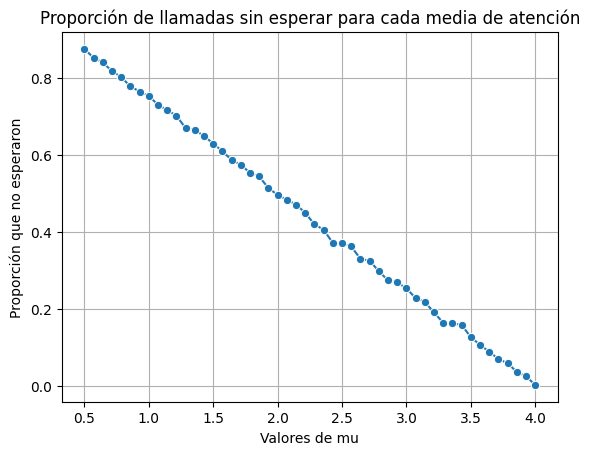

In [27]:
sns.lineplot(x=medias_db, y=sin_esperar, marker='o')
plt.grid()
plt.title('Proporción de llamadas sin esperar para cada media de atención')
plt.ylabel('Proporción que no esperaron')
plt.xlabel('Valores de mu')
plt.show()

# Ejercicio 4

## Importamos bibliotecas

## Cajeros

### Cajero Estandar

In [93]:
CAPACIDAD_BILLETES_DEPOSITOS= 2000
CAPACIDAD_BILLETES_EXTRACCIONES = 2000
VALOR_BILLETES = 100

In [94]:
class CajeroEstandar:
    def __init__(self, capacidad_billetes_depositos, capacidad_billetes_extracciones):
        self.capacidad_billetes_depositos = capacidad_billetes_depositos
        self.capacidad_billetes_extracciones = capacidad_billetes_extracciones
        
        self.iniciar_nuevo_dia()
        
    
    def depositar(self, billetes):    
        futuros_billetes_depositados  = self.billetes_depositados + billetes
        if futuros_billetes_depositados > self.capacidad_billetes_depositos:
            return False          
        self.billetes_depositados = futuros_billetes_depositados
        return True
    
    def extraer(self, billetes):
        futuros_billetes_extracciones = self.billetes_extracciones_disponibles - billetes
        if futuros_billetes_extracciones < 0:
            return False
        self.billetes_extracciones_disponibles = futuros_billetes_extracciones
        return True
    
    def iniciar_nuevo_dia (self):
        # Comienza el día con la carga completa para extracciones
        self.billetes_extracciones_disponibles = self.capacidad_billetes_extracciones
        
        # Comienza el día sin ningún depósito
        self.billetes_depositados = 0
    
    def obtener_cantidad_billetes(self):
        return self.billetes_extracciones_disponibles
       

In [95]:
cajero_estandar = CajeroEstandar(CAPACIDAD_BILLETES_DEPOSITOS, CAPACIDAD_BILLETES_EXTRACCIONES)

### Cajero Reciclador

In [96]:
CAPACIDAD = 2000
CANTIDAD_BILLETES_INCIAL = 2000

In [97]:
class CajeroReciclador:
    def __init__(self, capacidad, cantidad_billetes_inicial):
        self.capacidad = capacidad
        self.cantidad_billetes_inicial = cantidad_billetes_inicial
        self.iniciar_nuevo_dia()
        
    def depositar(self, billetes):
        futuros_billetes  = self.billetes + billetes
        if futuros_billetes > self.capacidad:
            return False
        self.billetes = futuros_billetes
        return True
    
    def extraer (self, billetes):
        futuros_billetes = self.billetes - billetes
        if futuros_billetes < 0:
            return False
        self.billetes = futuros_billetes
        return True
    
    def iniciar_nuevo_dia(self):
        self.billetes = self.cantidad_billetes_inicial
        
    def obtener_cantidad_billetes(self):
        return self.billetes
        

## Persona

In [98]:
# Personas
LIMITE_INFERIOR_DEPOSITOS = 10
LIMITE_SUPERIOR_DEPOSITOS = 110
LIMITE_INFERIOR_EXTRACCIONES = 3
LIMITE_SUPERIOR_EXTRACCIONES = 50
MEDIA_TIEMPO_DEPOSITOS = 5/60 # 5 minutos
MEDIA_TIEMPO_EXTRACCIONES = 90/3600 # 90 segundos = 0.025 horas

In [99]:
class Operacion:
    def __init__(self, tipo, tiempo, resultado):
        self.tipo = tipo
        self.tiempo = tiempo
        self.resultado = resultado

In [100]:
class Persona:
    def __init__(self,
                 limite_inferior_depositos, 
                 limite_superior_depositos, 
                 limite_inferior_extracciones,
                 limite_superior_extracciones,
                 media_tiempo_depositos,
                 media_tiempo_extracciones):
    
        self.limite_inferior_depositos = limite_inferior_depositos 
        self.limite_superior_depositos = limite_superior_depositos 
        self.limite_inferior_extracciones = limite_inferior_extracciones
        self.limite_superior_extracciones = limite_superior_extracciones
        self.media_tiempo_depositos = media_tiempo_depositos
        self.media_tiempo_extracciones = media_tiempo_extracciones
        
    def realizar_transaccion(self, cajero):
        random = np.random.uniform(0, 1, 1)[0]
        if random > 0.75:
            return self.realizar_deposito(cajero)
        return self.realizar_extraccion (cajero)
    
    def realizar_deposito (self, cajero):
        billetes = random.randint(self.limite_inferior_depositos, self.limite_superior_depositos)
        tiempo = np.random.exponential(self.media_tiempo_depositos)
        resultado = cajero.depositar(billetes)
        return Operacion('DEPOSITO', tiempo, resultado)
        
    def realizar_extraccion (self, cajero):
        billetes = random.randint(self.limite_inferior_extracciones, self.limite_superior_extracciones)
        tiempo = np.random.exponential(self.media_tiempo_extracciones)
        resultado =  cajero.extraer(billetes)
        return Operacion('EXTRACCION', tiempo, resultado) 

## Simulaciones

In [101]:
TIEMPO_MEDIO_ARRIBOS = 10/60 # horas

### Modelo la simulación

In [102]:
def obtener_arribos (tiempo_medio_arribos):
    t = 0
    arribos = [] 
    while True:
        t += np.random.exponential(tiempo_medio_arribos)    
        if t > 24:
            return arribos
        arribos.append(t)

In [103]:
def simular_dia(cajero, tiempo_medio_arribos):
    # Inicio un nuevo día en el cajero
    cajero.iniciar_nuevo_dia()
    t_libera_cajero = 0
    
    # Estadisticas del días
    estadisticas = {
        "cantidad_depositos":0,
        "cantidad_depositos_exitosos":0,
        "cantidad_depositos_fallidos":0,
        "cantidad_extracciones":0,
        "cantidad_extracciones_exitosas":0,
        "cantidad_extracciones_fallidas":0,
        "billetes_tras_transaccion" : [cajero.obtener_cantidad_billetes()],
        "tiempos_de_demora": [],
        "tiempo_medio_demoras" : 0
    }
    
    # obtengo los tiempo en que van a llegar las personas
    arribos = obtener_arribos(tiempo_medio_arribos)
               
    # Para cada uno de los tiempos de arribo
    
    # ti: tiempo i-esimo arribo
    # espera de la persona i
    
    for ti in arribos:
        ei = t_libera_cajero - ti
        
        # realiza una transaccion en el cajero
        operacion = Persona(LIMITE_INFERIOR_DEPOSITOS,
                            LIMITE_SUPERIOR_DEPOSITOS,
                            LIMITE_INFERIOR_EXTRACCIONES,
                            LIMITE_SUPERIOR_EXTRACCIONES,
                            MEDIA_TIEMPO_DEPOSITOS,
                            MEDIA_TIEMPO_EXTRACCIONES
                            ).realizar_transaccion(cajero)
            
        
        # Sino no esperé, porque el cajero estaba libre
        if ei <= 0:
            # el tiempo de espera de esa persona es 0
            ei = 0
            
            # el siguiente tiempo en el que se libera el cajero es el tiempo de llegada de la persona + lo que tarda en usarlo
            t_libera_cajero = ti + operacion.tiempo
        
        # Si si tengo que esperar    
        else:
            # El tiempo en que se libera, es el tiempo en que lo libero la persona anterior + el tiempo que esta persona tarde
            t_libera_cajero += operacion.tiempo 
            
        # Calculo tiempo de demora de la persona
        demora = ei + operacion.tiempo
        estadisticas["tiempos_de_demora"].append(demora)
        
        # calculo cantidad billetes en cajero
        estadisticas["billetes_tras_transaccion"].append(cajero.obtener_cantidad_billetes())
        
        # Actualizo estadisticas con rlosd datos de la operacion
        if operacion.tipo == 'DEPOSITO':
            estadisticas["cantidad_depositos"] += 1
            if operacion.resultado == True:
                estadisticas["cantidad_depositos_exitosos"] +=1
            else:
                estadisticas["cantidad_depositos_fallidos"] += 1
        
        else:
            estadisticas["cantidad_extracciones"] += 1
            if operacion.resultado == True:
                estadisticas["cantidad_extracciones_exitosas"] +=1
            else:
                estadisticas["cantidad_extracciones_fallidas"] += 1
    
        # Si el tiempo en que se libera es mayor a 24 corto
        if t_libera_cajero >= 24:
            break
        
    # Concluido el dia calculo el tiempo medio de demoras
    estadisticas["tiempo_medio_demoras"] = sum(estadisticas["tiempos_de_demora"])/len(estadisticas["tiempos_de_demora"])
    
    return estadisticas

In [104]:
def realizar_simulacion (cajero, tiempo_medio_arribos, cantidad_de_dias):
    estadisticas_por_dia = []
    
    estadisticas = {
        "cantidad_depositos":0,
        "cantidad_depositos_exitosos":0,
        "cantidad_depositos_fallidos":0,
        "cantidad_extracciones":0,
        "cantidad_extracciones_exitosas":0,
        "cantidad_extracciones_fallidas":0,
        "billetes_tras_transaccion" : [cajero.obtener_cantidad_billetes()],
        "tiempos_de_demora": [],
        "tiempo_medio_demoras" : 0
    }
    
    for x in range (0, cantidad_de_dias):
        estadisticas_por_dia.append(simular_dia(cajero, tiempo_medio_arribos))
        
    for estadistica in estadisticas_por_dia:
        estadisticas["cantidad_depositos"] += estadistica["cantidad_depositos"]
        estadisticas["cantidad_depositos_exitosos"] += estadistica["cantidad_depositos_exitosos"]
        estadisticas["cantidad_depositos_fallidos"] += estadistica["cantidad_depositos_fallidos"]
        estadisticas["cantidad_extracciones"] += estadistica["cantidad_extracciones"]
        estadisticas["cantidad_extracciones_exitosas"] += estadistica["cantidad_extracciones_exitosas"]
        estadisticas["cantidad_extracciones_fallidas"] += estadistica["cantidad_extracciones_fallidas"]
        estadisticas["billetes_tras_transaccion"] += estadistica["billetes_tras_transaccion"]
        estadisticas["tiempos_de_demora"] += estadistica["tiempos_de_demora"]
        estadisticas["tiempo_medio_demoras"] = sum(estadisticas["tiempos_de_demora"])/len(estadisticas["tiempos_de_demora"])
        
    return estadisticas      

### Consignas


####  a) Simular 1000 días completos de 24 hrs.

In [105]:
cajero_reciclador_1000 = CajeroReciclador(CAPACIDAD,CANTIDAD_BILLETES_INCIAL)
estadisticas_1000 = realizar_simulacion(cajero_reciclador_1000, TIEMPO_MEDIO_ARRIBOS, 1000)

##### Despositos

In [106]:
print ("Cantidad de depositos: " + str(estadisticas_1000["cantidad_depositos"]))
print ("exitosos: " + str(estadisticas_1000["cantidad_depositos_exitosos"]))
print ("fallidos: " + str(estadisticas_1000["cantidad_depositos_fallidos"]))
print ("% fallidos: " + str((estadisticas_1000["cantidad_depositos_fallidos"] / estadisticas_1000["cantidad_depositos"])*100))

Cantidad de depositos: 36139
exitosos: 33576
fallidos: 2563
% fallidos: 7.092061208113119


##### Extracciones

In [107]:
print ("cantidad de extracciones: " + str(estadisticas_1000["cantidad_extracciones"]))
print ("exitosas: " + str(estadisticas_1000["cantidad_extracciones_exitosas"]))
print ("fallidas: " + str(estadisticas_1000["cantidad_extracciones_fallidas"]))
print ("% fallidas: " + str((estadisticas_1000["cantidad_extracciones_fallidas"] / estadisticas_1000["cantidad_extracciones"])*100))

cantidad de extracciones: 107458
exitosas: 107400
fallidas: 58
% fallidas: 0.05397457611345828


#### b) Para un día en particular graficar la cantidad de billetes en el cajero luego de cada transacción.

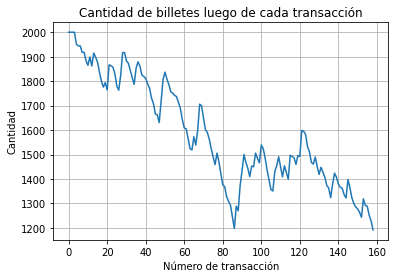

In [108]:
cajero_reciclador_1 = CajeroReciclador(CAPACIDAD,CANTIDAD_BILLETES_INCIAL)
estadisticas_1 = realizar_simulacion(cajero_reciclador_1, TIEMPO_MEDIO_ARRIBOS, 1)

plt.grid()
plt.plot(estadisticas_1["billetes_tras_transaccion"])
plt.title('Cantidad de billetes luego de cada transacción')
plt.ylabel('Cantidad')
plt.xlabel('Número de transacción')
plt.show()

#### c) Calcular el tiempo medio que los clientes demoraron en el sistema (espera + utilización del cajero)

In [109]:
print("Tiempo medio demoras en los 1000 dias: " + str(estadisticas_1000["tiempo_medio_demoras"]))
print("Tiempo medio demoras en 1 dias: " + str(estadisticas_1["tiempo_medio_demoras"]))

Tiempo medio demoras en los 1000 dias: 0.056444163783774905
Tiempo medio demoras en 1 dias: 0.04911578562181909


#### d) ¿Recomienda a la entidad que implemente el cambio de cajero?

La entidad conoce que con el cajero actual el 20% de los clientes se retiraba sin poder extraer dinero, y sólo
acepta cambiarlo si este porcentaje disminuye.

In [110]:
# En la simulacion de 1000 dias vimos que 
print ("% extracciones fallidas: " + str((estadisticas_1000["cantidad_extracciones_fallidas"] / estadisticas_1000["cantidad_extracciones"]) *100))

% extracciones fallidas: 0.05397457611345828


In [111]:
# En la simulacion de 1 dia vimos que 
print ("% extracciones fallidas: " + str((estadisticas_1["cantidad_extracciones_fallidas"] / estadisticas_1["cantidad_extracciones"]) *100))

% extracciones fallidas: 0.0


Respuesta: Si, se recomienda el cambio de cajero

### ¿ Qué pasa con el cajero estandar?

### Si miro 1 solo dia 

In [112]:
cajero_estandar_1 = CajeroEstandar(CAPACIDAD_BILLETES_DEPOSITOS, CAPACIDAD_BILLETES_EXTRACCIONES)
estadisticas_estandar_1 = realizar_simulacion(cajero_estandar_1, TIEMPO_MEDIO_ARRIBOS, 1)

##### Despositos

In [113]:
print ("Cantidad de depositos: " + str(estadisticas_estandar_1["cantidad_depositos"]))
print ("exitosos: " + str(estadisticas_estandar_1["cantidad_depositos_exitosos"]))
print ("fallidos: " + str(estadisticas_estandar_1["cantidad_depositos_fallidos"]))
print ("% fallidos: " + str((estadisticas_estandar_1["cantidad_depositos_fallidos"] / estadisticas_estandar_1["cantidad_depositos"])*100))

Cantidad de depositos: 35
exitosos: 33
fallidos: 2
% fallidos: 5.714285714285714


##### Extracciones

In [119]:
print ("Cantidad de extracciones: " + str(estadisticas_estandar_1["cantidad_extracciones"]))
print ("exitosas: " + str(estadisticas_estandar_1["cantidad_extracciones_exitosas"]))
print ("fallidas: " + str(estadisticas_estandar_1["cantidad_extracciones_fallidas"]))
print ("% fallidas: " + str((estadisticas_estandar_1["cantidad_extracciones_fallidas"] / estadisticas_estandar_1["cantidad_extracciones"])*100))

Cantidad de extracciones: 103
exitosas: 77
fallidas: 26
% fallidas: 25.24271844660194


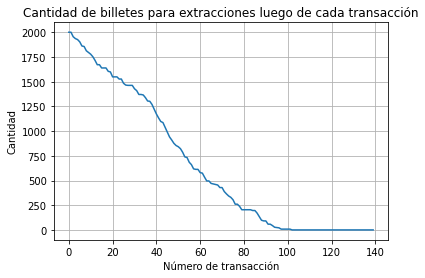

In [120]:
plt.grid()
plt.plot(estadisticas_estandar_1["billetes_tras_transaccion"])
plt.title('Cantidad de billetes para extracciones luego de cada transacción')
plt.ylabel('Cantidad')
plt.xlabel('Número de transacción')
plt.show()

### Si miro 1000 dias 

In [116]:
cajero_estandar_1000 = CajeroEstandar(CAPACIDAD_BILLETES_DEPOSITOS, CAPACIDAD_BILLETES_EXTRACCIONES)
estadisticas_estandar_1000 = realizar_simulacion(cajero_estandar_1000, TIEMPO_MEDIO_ARRIBOS, 1000)

##### Despositos

In [117]:
print ("Cantidad de depositos: " + str(estadisticas_estandar_1000["cantidad_depositos"]))
print ("exitosos: " + str(estadisticas_estandar_1000["cantidad_depositos_exitosos"]))
print ("fallidos: " + str(estadisticas_estandar_1000["cantidad_depositos_fallidos"]))
print ("% fallidos: " + str((estadisticas_estandar_1000["cantidad_depositos_fallidos"] / estadisticas_estandar_1000["cantidad_depositos"])*100))

Cantidad de depositos: 35627
exitosos: 31903
fallidos: 3724
% fallidos: 10.452746512476493


##### Extracciones

In [118]:
print ("Cantidad de extracciones: " + str(estadisticas_estandar_1000["cantidad_extracciones"]))
print ("exitosas: " + str(estadisticas_estandar_1000["cantidad_extracciones_exitosas"]))
print ("fallidas: " + str(estadisticas_estandar_1000["cantidad_extracciones_fallidas"]))
print ("% fallidas: " + str((estadisticas_estandar_1000["cantidad_extracciones_fallidas"] /estadisticas_estandar_1000["cantidad_extracciones"])*100))

Cantidad de extracciones: 107224
exitosas: 76540
fallidas: 30684
% fallidas: 28.616727598298887
